In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [4]:
class GenericRNN(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        
        self.lstm = nn.RNN(self.in_no, self.H_no, self.layer_no, batch_first=True)
        self.linear = nn.Linear(self.H_no, 1)
        
    def forward(self, S):
        T_data = S.shape[0]
        
        S = S.unsqueeze(0) #(1, T_data, in_no)
        lstm_out, hs = self.lstm(S) #(1, T_data, H_no)
        out = self.linear(lstm_out.squeeze(0)).flatten()
        
        return out

In [5]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [6]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 50
layer_no = 2
in_no = e_idx.shape[0] + i_idx.shape[0]
#in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

In [7]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [8]:
model = GenericRNN(T_no, H_no, layer_no, in_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

23101


In [ ]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])))
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])))
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print(i, test_score, test_mse)


<ipython-input-9-6a675939e810>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 5.716085433959961e-05 0.04180464893579483
49 0.021222233772277832 0.026658277958631516
99 0.09602051973342896 0.02469954453408718
149 0.25806713104248047 0.020177900791168213
199 0.26031434535980225 0.020243803039193153
249 0.2602464556694031 0.020139671862125397
299 0.2801908850669861 0.019711114466190338
349 0.28171366453170776 0.019892847165465355
399 0.2633225917816162 0.020052364096045494
449 0.2664461135864258 0.020000213757157326
499 0.2697111964225769 0.01988816075026989
549 0.24764353036880493 0.020786654204130173
599 0.28117990493774414 0.0196831114590168
649 0.2755473852157593 0.019712330773472786
699 0.25082504749298096 0.02047840692102909


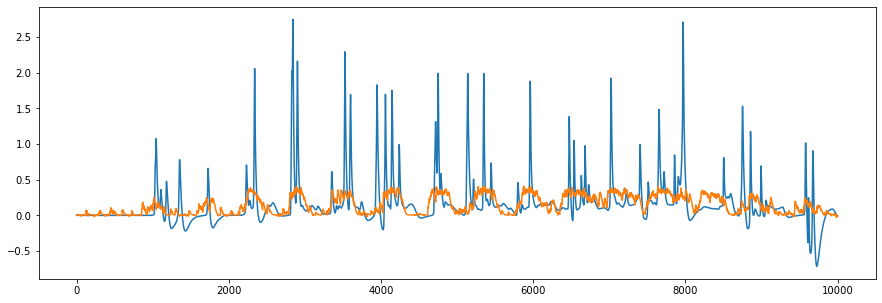

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])

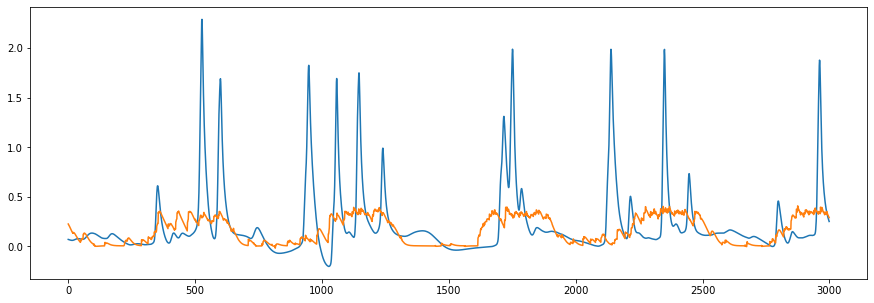

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])